In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import importlib as imp
import seaborn as sns
from tifffile import TiffFile
import umap
import pickle

Xenium initial pixel size 0.2125 microns.
Reduce the size to 1/4. Pizel size 0.85 microns.
Visium pixel size 55/73.06=0.7528 microns.

In [2]:
adata_xe = sc.read_10x_h5(filename='F:/Ziqian Zheng/Spatial omics/Xenium/B1/cell_feature_matrix.h5')
df = pd.read_csv('F:/Ziqian Zheng/Spatial omics/Xenium/B1/cells.csv')
df.set_index(adata_xe.obs_names, inplace=True)
adata_xe.obs = df.copy()
adata_xe.obsm["spatial"] = adata_xe.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
coordinate_xe = adata_xe.obsm["spatial"]

# adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad")
adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/SCRNA/mousebrain/NewMerge_harmony_noDAM.h5ad")
common_gene = list(set(adata_xe.var_names) & set(adata_sc.var_names))
adata_sc = adata_sc[:, common_gene]
adata_xe = adata_xe[:, common_gene]

type_list = sorted(list(np.unique(adata_sc.obs['cell_type'])))
n_type = len(type_list)
adata_xe.uns['type_list'] = type_list

C:\Users\zzheng92\AppData\Local\Temp\5\ipykernel_29188\3172523978.py:16: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_xe.uns['type_list'] = type_list


In [3]:
X_train = adata_sc.X.toarray()
X_test = adata_xe.X.toarray()
y_train = adata_sc.obs['cell_type'].to_numpy()

In [4]:
X_train = 1000*X_train/(np.sum(X_train, axis=1, keepdims=True)+1e-8)
X_test = 1000*X_test/(np.sum(X_test, axis=1, keepdims=True)+1e-8)

In [5]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=16)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
adata_xe.obs['cell_type'] = y_pred
adata_xe.obs['cell_type'].value_counts()

CPU times: total: 5min 7s
Wall time: 21.4 s


cell_type
Oligo          24099
Astro          15406
L2/3 IT CTX     8841
Microglia       7910
L4/5 IT CTX     6309
CAs             6060
Endo            5484
Pvalb           4906
L6 CT CTX       4789
Sst             3641
L5 IT CTX       3530
Sncg            3083
DG              3062
Lamp5           2144
L5 PT CTX       1644
Vip             1447
L6b CTX         1004
L5/6 NP CTX      724
Pericyte         555
TCell            117
Macrophage        66
BCell             10
Name: count, dtype: int64

In [6]:
adata_xe_copy = adata_xe.copy()
sc.pp.normalize_per_cell(adata_xe_copy, counts_per_cell_after=1e4)
# sc.pp.log1p(adata_xe_copy)
adata_xe_copy.raw = adata_xe_copy
sc.pp.neighbors(adata_xe_copy, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_xe_copy)

         Falling back to preprocessing with `sc.pp.pca` and default params.


C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


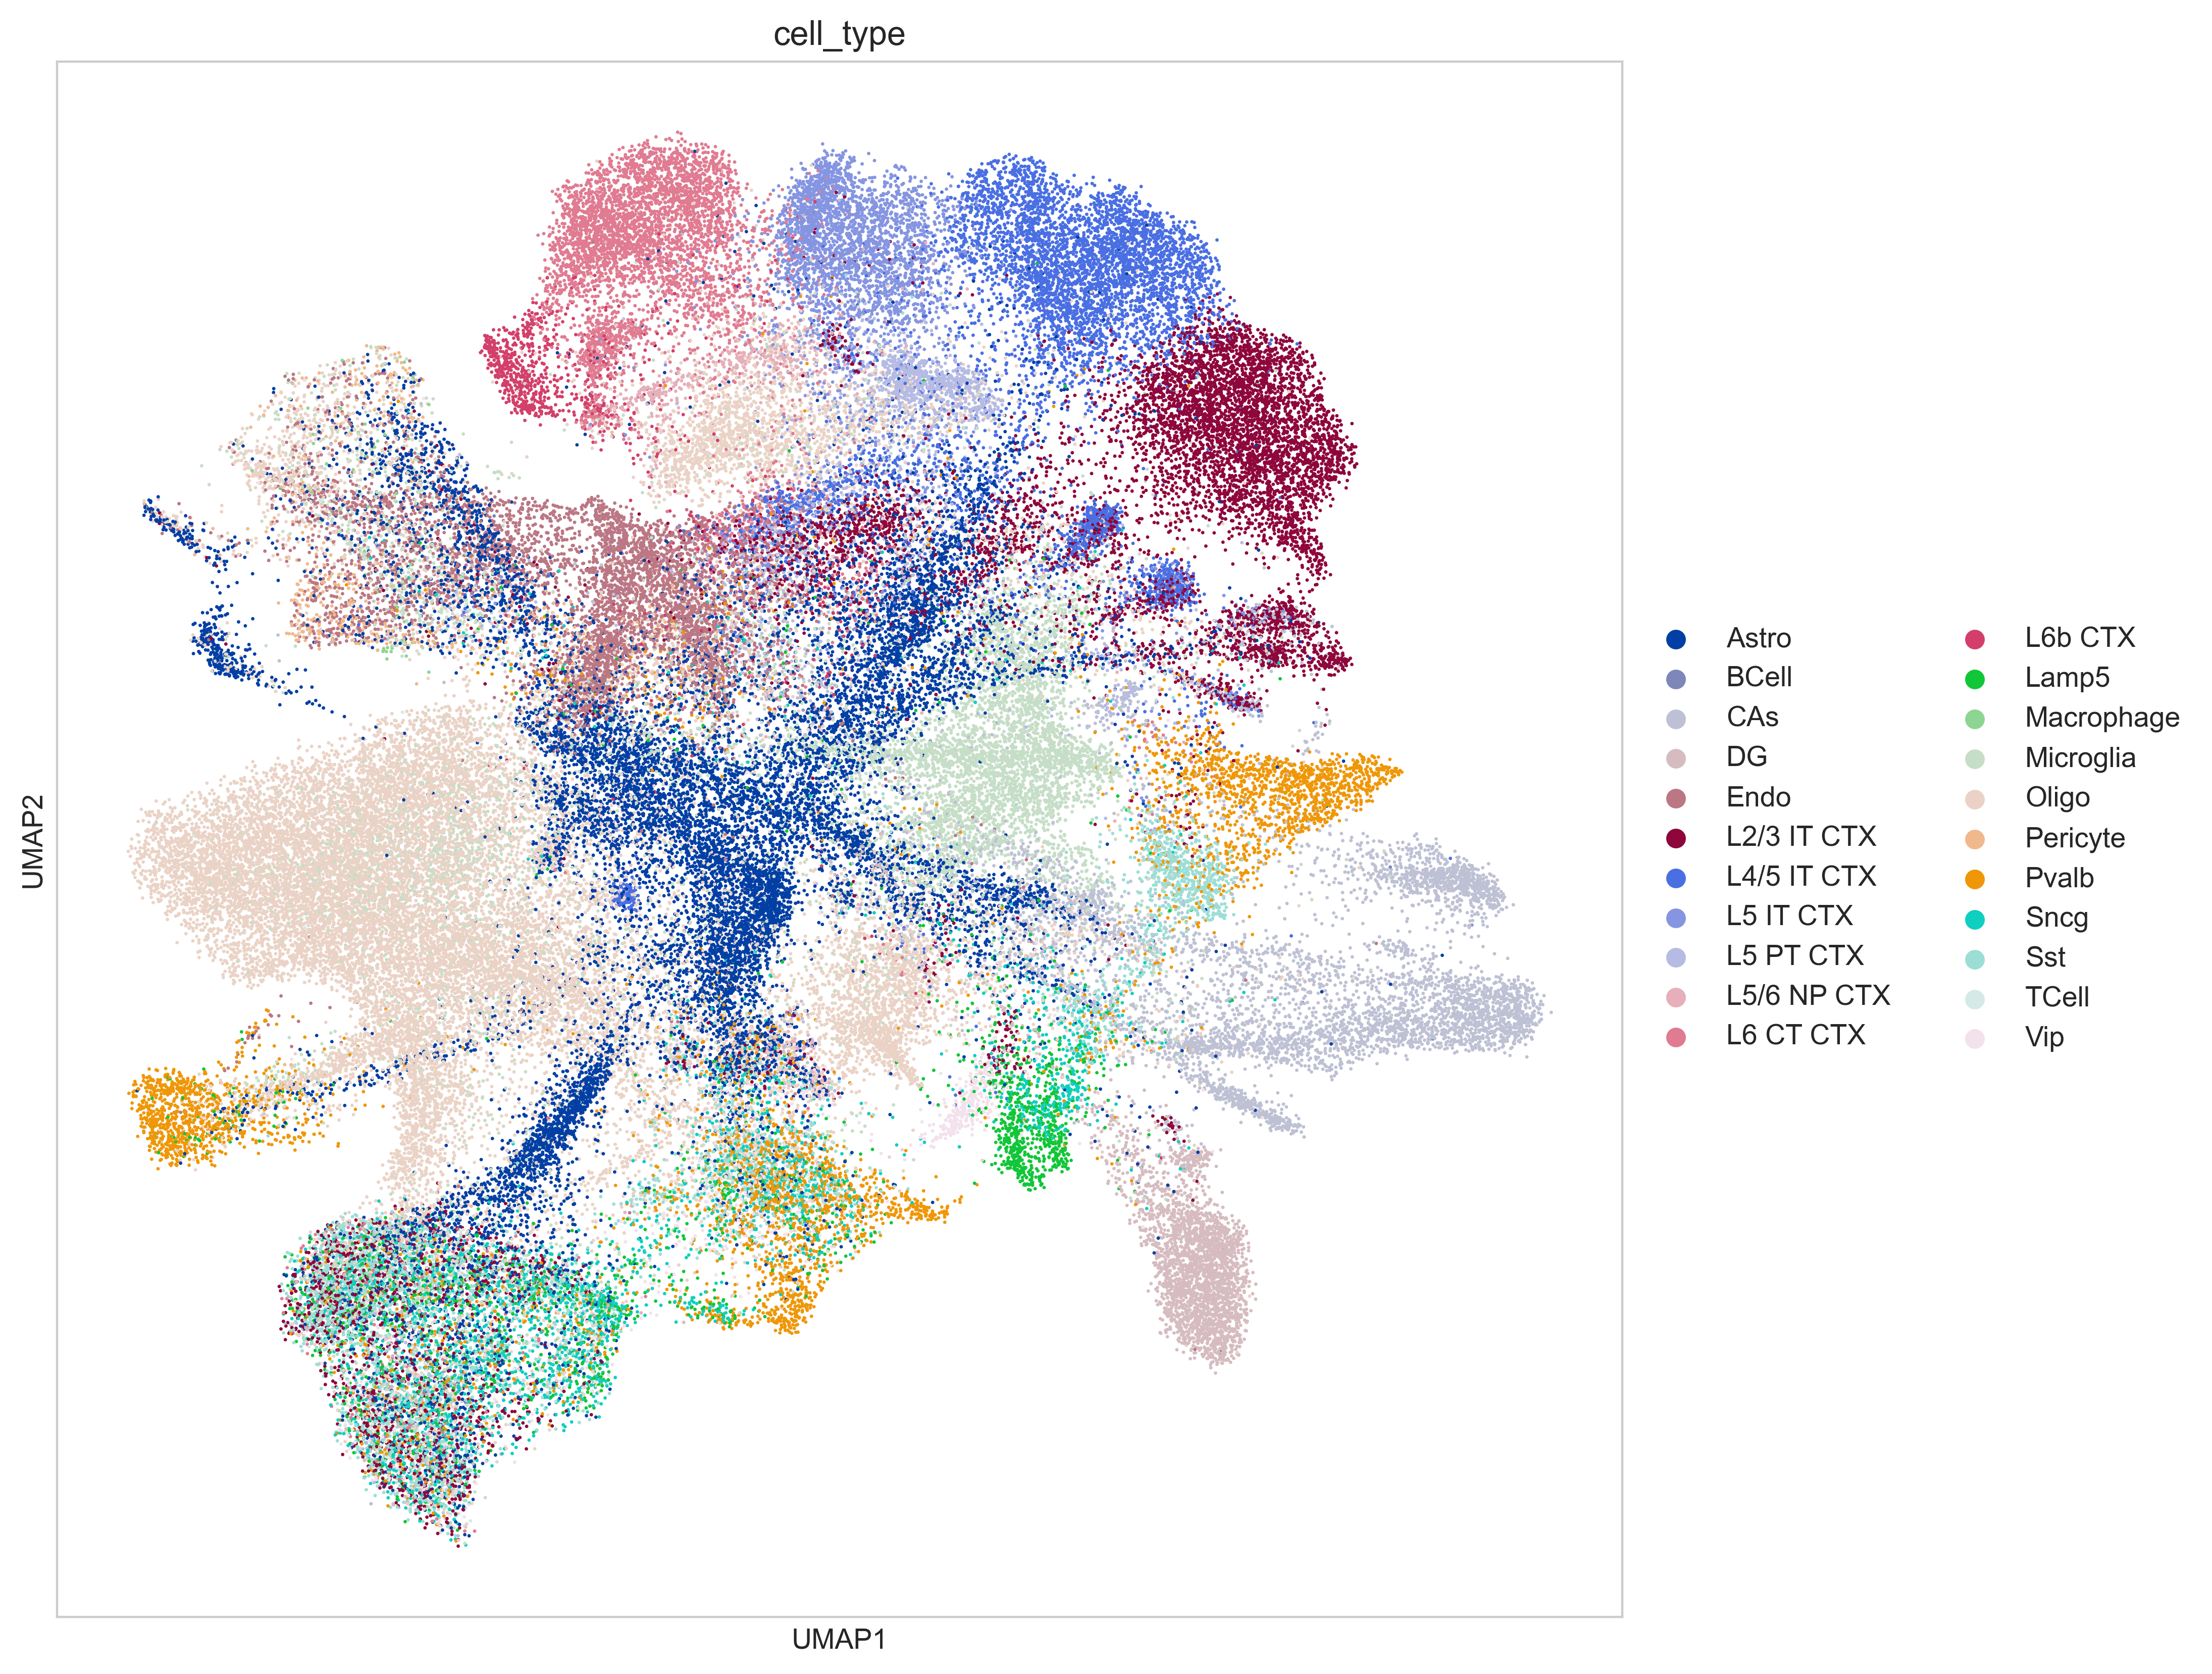

In [7]:
with mpl.rc_context({'figure.figsize': [10, 10], 'figure.dpi': 400}):
    sc.pl.umap(adata_xe_copy, color='cell_type', size=6)

In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(np.log(X_test+1))
embedding_df = pd.DataFrame({'x':embedding[:, 0], 'y':embedding[:, 1], 'cell_type':adata_xe.obs['cell_type']})
embedding.shape

(104831, 2)

In [10]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
del cmap1, cmap2, cmap3, colors1, colors2, colors3
sns.palplot(contrast_palette)

In [12]:
# import colorcet as cc
# palette = sns.color_palette(cc.glasbey, n_colors=20)
# sns.palplot(palette)
plt.figure(figsize=(11, 10), dpi=300)
ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=1, hue='cell_type', palette=contrast_palette)
# ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=0.3, hue='cell_type', palette=sns.color_palette())
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('results/Xenium_new/umap_xenium_new.jpg', dpi=500, bbox_inches = 'tight')

C:\Users\zzheng92\AppData\Local\Temp\5\ipykernel_29188\742964491.py:5: UserWarning: The palette list has more values (25) than needed (22), which may not be intended.
  ax = sns.scatterplot(data = embedding_df, x='x', y='y', s=1, hue='cell_type', palette=contrast_palette)


In [13]:
type_list_xe = list(sorted(adata_xe.obs['cell_type'].unique()))
X_test_mean = np.zeros((len(type_list_xe), X_test.shape[1]))
for i, type_ in enumerate(type_list_xe):
    X_test_mean[i] = np.mean(X_test[y_pred==type_], axis=0)
X_test_mean_argmax = np.argmax(X_test_mean, axis=0)
X_test_sort = X_test[np.argsort(y_pred)]
X_test_sort = X_test_sort[:, np.argsort(X_test_mean_argmax)]
X_train_sort = X_train[np.argsort(y_train)]
X_train_sort = X_train_sort[:, np.argsort(X_test_mean_argmax)]

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(40, 8), dpi=50)
# palette = sns.cubehelix_palette(n_type, light=.9, dark=.1, reverse=True, start=1, rot=-2)
palette_dict = dict(zip(map(str, type_list), contrast_palette))
col_colors = adata_xe.obs['cell_type'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_test_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])
plt.savefig('results/Xenium_new/heatmap_xe.jpg', dpi=500, bbox_inches = 'tight')

In [ ]:
adata_sc.obs['cell_type'] = list(adata_sc.obs['cell_type'].values)

In [37]:
col_colors = adata_sc.obs['cell_type'].sort_values().map(palette_dict).to_numpy()
g = sns.clustermap(X_train_sort.T, vmax=40, row_cluster=False, col_cluster=False, xticklabels=False, yticklabels=False,
                   figsize=(16, 10), col_colors=col_colors)
for label in type_list:
    g.ax_col_dendrogram.bar(0, 0, color=palette_dict[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .01, .45])
plt.savefig('results/Xenium_new/heatmap_sc.jpg', dpi=500, bbox_inches = 'tight')

In [38]:
with TiffFile('F:/Ziqian Zheng/Spatial omics/Xenium/B1/morphology_mip.ome.tif') as tif:
    Xenium = tif.asarray()
del tif
# Initially, the pixel size of Xenium 0.2125 microns.
Xenium = Xenium[::4, ::4]  # Make the size of the image to be 1/4. Now the pixel size is 0.85 microns.

In [39]:
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
adata_st.var_names_make_unique()
adata_st.uns['type_list'] = type_list
coordinate_st = adata_st.obsm["spatial"]

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [40]:
HE = cv.imread('F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/Sample221.jpg')
HE = HE[:, :, [2, 1, 0]]

In [43]:
plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(HE)
plt.scatter(coordinate_st[:, 0], coordinate_st[:, 1], s=1)
plt.savefig('results/Xenium_new/test.jpg')

In [44]:
plt.figure(figsize=(9, 8), dpi=60)
plt.imshow(Xenium)
plt.scatter(coordinate_xe[::10, 0]/0.85, coordinate_xe[::10, 1]/0.85, s=0.1)
# plt.scatter(1000, 4000)
plt.savefig('results/Xenium_new/test.jpg')

In [45]:
# Visium pixel size 0.7528 microns.
Xenium_resize = cv.resize(Xenium, None, fx=0.85/0.7528, fy=0.85/0.7528, interpolation=cv.INTER_CUBIC)
rows , cols = HE.shape[:2]
theta = 3.37
trans = [7050, 10550]
M = np.float32([[np.cos(theta), -np.sin(theta), trans[0]], [np.sin(theta), np.cos(theta), trans[1]]])
Xenium_resize_Affine = cv.warpAffine(Xenium_resize, M, (cols, rows))
coordinate_xe_resize = coordinate_xe/0.7528
coordinate_xe_rotate = coordinate_xe_resize @ M[:, :2].T + trans
adata_xe.obs[['x_centroid', 'y_centroid']] = coordinate_xe_rotate

In [46]:
from matplotlib.colors import LinearSegmentedColormap
n_colors = np.max(Xenium)
color_array = plt.get_cmap('binary')(range(n_colors))
color_array[:,-1] = np.linspace(0, 2.0, n_colors)
color_array[n_colors//3-1:,-1] = 1
cmap_name = 'binary_alpha'
map_object = LinearSegmentedColormap.from_list(name=cmap_name, colors=color_array)
plt.register_cmap(cmap=map_object, name=cmap_name)
plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(HE, alpha=1)
plt.imshow(Xenium_resize_Affine, alpha=1, cmap=cmap_name)
plt.savefig('results/Xenium_new/Xenium_affine.jpg', dpi=2000)

C:\Users\zzheng92\AppData\Local\Temp\5\ipykernel_29188\1776504243.py:8: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object, name=cmap_name)


In [47]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(Xenium_resize_Affine, alpha=1, cmap=cmap_name)
plt.scatter(coordinate_xe_rotate[::10, 0], coordinate_xe_rotate[::10, 1], s=0.1)
plt.scatter(coordinate_st[:, 0], coordinate_st[:, 1], s=1)
plt.savefig('results/Xenium_new/test.jpg')

In [48]:
# Xenium_resize_Affine = np.save('results/Xenium/Xenium_resize_Affine.npy', Xenium_resize_Affine)

In [49]:
distance = np.sum((coordinate_st[:, :, np.newaxis] - coordinate_xe_rotate.T) ** 2, axis=1)
truth_df = pd.DataFrame({type_: [0]*len(adata_st) for type_ in type_list})
truth_df.index = adata_st.obs_names
for i in range(len(adata_st)):
    cell_index = np.where(distance[i] < 36.5**2)[0]
    if len(cell_index) > 0:
        cells = adata_xe.obs['cell_type'].to_numpy()[cell_index]
        for cell in cells:
            truth_df.iloc[i, truth_df.columns.get_loc(cell)] += 1
adata_st.obsm['truth'] = truth_df

In [84]:
row_sum = np.sum(truth_df.to_numpy(), axis=1)
row_sum[row_sum<1] = 1
truth_normalized = truth_df/row_sum[:, np.newaxis]
adata_st.obs[type_list] = truth_df.to_numpy()

In [85]:
Xenium_resize_Affine_copy = Xenium_resize_Affine.copy()
threshold = 1500
Xenium_resize_Affine_copy[Xenium_resize_Affine_copy>threshold] = threshold
Xenium_resize_Affine_copy = threshold - Xenium_resize_Affine_copy
Xenium_resize_Affine_copy = np.clip(Xenium_resize_Affine_copy * (255 / np.max(Xenium_resize_Affine_copy)), 0, 255).astype(np.uint8)
Xenium_background = cv.cvtColor(Xenium_resize_Affine_copy, cv.COLOR_GRAY2RGB)

In [86]:
type_list_order = ['L2/3 IT CTX', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PT CTX', 'L5/6 NP CTX', 'L6 CT CTX', 'L6b CTX', 'CAs', 'DG', 'Lamp5', 'Pvalb', 'Sncg',
                   'Sst', 'Vip', 'Endo', 'Astro', 'Oligo', 'Pericyte', 'Macrophage', 'Microglia', 'Neutrophil', 'TCell', 'BCell']
adata_st.var.rename(index={'Lamp5': 'Lamp5_g', 'Pvalb': 'Pvalb_g', 'Sst': 'Sst_g', 'Vip': 'Vip_g', 'Sncg': 'Sncg_g'}, inplace=True)
vmax = np.quantile(adata_st.obs[type_list_order].to_numpy(), 0.98, axis=0)
vmax[vmax < 1] = 1
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list_order, vmin=0, vmax=list(vmax), size=1.3, show=False, ncols=7, img=Xenium_background, scale_factor=1)
    ax[0].get_figure().savefig('results/Xenium_new/number.jpg', bbox_inches='tight')

C:\Users\zzheng92\Anaconda3\envs\spotiphy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:470: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(


In [56]:
adata_st.write_h5ad('results/Xenium_new/adata_st.h5ad')

In [57]:
adata_xe.write_h5ad('results/Xenium_new/adata_xe.h5ad')

In [69]:
gene_anno = pd.read_excel('results/Xenium_new/Xenium_gene_anno_plan.xlsx', header=None)
gene_anno[2] = gene_anno[2].astype(str)
gene_anno

0                 1      2
0    Acsbg1        Astrocytes  Astro
1      Aqp4        Astrocytes  Astro
2     Cdh20        Astrocytes  Astro
3      Clmn        Astrocytes  Astro
4      Gfap        Astrocytes  Astro
..      ...               ...    ...
243    Penk  Vip interneurons    Vip
244   Pthlh  Vip interneurons    Vip
245  Sorcs3  Vip interneurons    Vip
246  Thsd7a  Vip interneurons    Vip
247     Vip  Vip interneurons    Vip

[248 rows x 3 columns]

In [71]:
type_list_anno = sorted(list(gene_anno[2].unique()))
type_list_anno

['Astro',
 'CAs',
 'DG',
 'Endo',
 'L2/3 IT CTX',
 'L4/5 IT CTX',
 'L5 IT CTX',
 'L5 PT CTX',
 'L5/6 NP CTX',
 'L6 CT CTX',
 'L6 IT',
 'L6b CTX',
 'Lamp5',
 'Microglia',
 'Oligo',
 'Pericyte',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip',
 'nan']

In [76]:
type_gene_dict = {}
for i in range(len(gene_anno)):
    if gene_anno.iloc[i, 0] in adata_xe.var_names:
        if gene_anno.iloc[i, 2] in type_gene_dict:
            type_gene_dict[gene_anno.iloc[i, 2]] += [adata_xe.var_names.get_loc(gene_anno.iloc[i, 0])]
        else:
            type_gene_dict[gene_anno.iloc[i, 2]] = [adata_xe.var_names.get_loc(gene_anno.iloc[i, 0])]
for key in type_gene_dict.keys():
    type_gene_dict[key] = np.array(type_gene_dict[key])

In [80]:
expression_marker = np.zeros((len(adata_st), len(type_list_anno)))
X = adata_xe.X.toarray()
for i in range(len(adata_st)):
    cell_index = np.where(distance[i] < 36.5**2)[0]
    if len(cell_index) > 0:
        expression_temp = np.array(X[cell_index])
        for j, type_ in enumerate(type_list_anno):
            if np.ndim(expression_temp) > 1:
                expression_marker[i, j] = np.sum(np.mean(expression_temp[:, type_gene_dict[type_]], axis=1))
            else:
                expression_marker[i, j] = np.mean(expression_temp[type_gene_dict[type_]])

In [81]:
adata_st.obs[type_list_anno] = expression_marker
with mpl.rc_context({'figure.figsize': [5, 5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list_anno, vmin=0, vmax='p99.8', size=1.3, show=False, ncols=5, img=Xenium_background, scale_factor=1)
    ax[0].get_figure().savefig('results/Xenium_new/marker_gene.jpg', bbox_inches='tight')